In [1]:
import os
import gzip
from tqdm.auto import tqdm
from pathlib import Path
from math import isclose, ceil
from itertools import product
from itertools import combinations_with_replacement, islice
from collections import defaultdict
import random
import pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.colors
import matplotlib.cm
from matplotlib import gridspec

import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.manifold import TSNE
import skimage.transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from deep_ei import topology_of, ei_of_layer, sensitivity_of_layer, \
                    ei_of_layer_matrix, sensitivity_of_layer_matrix

In [2]:
########### Set Device ############
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [3]:
BINS = 16
MNIST_LAYERS = [(25, 6), (6, 6), (6, 6), (6, 5)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 5 # epochs per measurement
EPOCHS = 500
BATCH_SIZE = 50

top_str = ""
for i, l in enumerate(MNIST_LAYERS):
    if i == len(MNIST_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"
print(top_str)

25-6-6-6-5


### Load up MNIST dataset

In [4]:
dir_path = Path().absolute()
dataset_path = dir_path / "datasets/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')


mnist0_4 = list(filter(lambda t: t[1].argmax() < 5, mnist))
for i, t in enumerate(mnist0_4):
    idx = t[1].argmax()
    new_onehot = np.zeros(5,)
    new_onehot[idx] = 1.0
    mnist0_4[i] = (t[0], new_onehot)
print('Reduced dataset to only 0-4 examples')

# ///////////////////////////////////////////
#               DEFINE `Dataset`
# ///////////////////////////////////////////
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, width=5, transform=None):
        """We save the dataset images as torch.tensor since saving 
        the dataset in memory inside a `Dataset` object as a 
        python list or a numpy array causes a multiprocessiing-related 
        memory leak."""
        self.images, self.labels = zip(*data)
        self.images = torch.from_numpy(np.array(self.images)).to(dtype)
        self.labels = torch.tensor(self.labels).to(dtype)
        self.width = width
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image = skimage.transform.resize(image.reshape((28, 28)), (self.width, self.width))
        if self.transform:
            image, label = self.transform((image, label))
        return image.flatten(), label

training_data = MNISTDataset(mnist0_4[:25000], width=5)
testing_data = MNISTDataset(mnist0_4[25000:], width=5)
   
training_loader = torch.utils.data.DataLoader(training_data, 
                            batch_size=BATCH_SIZE,
                            shuffle=True)

training_metrics_loader = torch.utils.data.DataLoader(training_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=False)

testing_loader = torch.utils.data.DataLoader(testing_data, 
                            batch_size=BATCH_SIZE,
                            shuffle=False)

testing_metrics_loader = torch.utils.data.DataLoader(testing_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=False)

Dataset acquired
Loaded data to variable `mnist`
Reduced dataset to only 0-4 examples


### Load up MNIST networks

In [5]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/small-mnist-phi/25-6-6-6-5_8bins_fixedlonger/run3-frames')]


In [6]:
all(d.exists() for d in run_folders)

True

In [7]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
    for (start_i, end_i) in combinations_with_replacement(range(len(MNIST_LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [8]:
mnist_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for mnist_run_datapoints in mnist_runs_datapoints:
    mnist_run_datapoints.sort(key=lambda f: f['batches'])

In [9]:
mnist_ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'T3',
    4: 'Y'
}

In [10]:
database = defaultdict(dict)

### first let's calculate EIs

In [11]:
t = tqdm(total=len(mnist_runs_datapoints) * 4)
for i, frames in enumerate(mnist_runs_datapoints):
    database[i+1] = {}
    ls = []
    for (in_n, out_n) in MNIST_LAYERS:
        ls.append(nn.Linear(in_n, out_n, bias=False))
        ls.append(nn.Sigmoid())
    final_network = nn.Sequential(*ls).to(device)
    final_top = topology_of(final_network, input=torch.zeros((1, 25)).to(device))
    final_network.load_state_dict(frames[-1]['model'])
    
    lyrs = [0, 2, 4, 6]
    database[i+1]['EIs'] = {}
    for l in lyrs:
        database[i+1]['EIs'][l] = ei_of_layer_matrix(final_network[l], final_top,
                                                        samples=int(2e5),
                                                        in_range=(0, 1),
                                                        in_bins=8,
                                                        out_range=(0, 1),
                                                        out_bins=8,
                                                        activation=nn.Sigmoid(),
                                                        device=device)
        t.update()

## perform ablation

In [12]:
t = tqdm(total=len(mnist_runs_datapoints) * 10)

for r, frames in enumerate(mnist_runs_datapoints):
    database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 10):
        
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4, 6]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = database[r+1]['EIs'][l]
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            start = int((percentile / 100 * len(indices_and_values)))
            end = int(((percentile + 10) / 100 * len(indices_and_values)))
#             print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

In [19]:
def infernoMap(i, n): # i = 1, 2, ... n
    colormap = matplotlib.cm.get_cmap("inferno")
    return colormap((1.0 * i / n)*0.8 + 0.0)

In [21]:
database[1]['EIs'][6]

(6, 5)

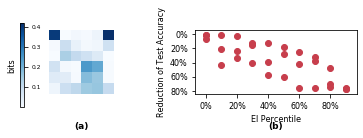

In [112]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
im = ax.imshow(database[1]['EIs'][4], cmap='Blues')
ax.axis('off')
cax = fig.add_axes([0.1, 0.2, 0.01, 0.65])
cb = fig.colorbar(im, orientation='vertical', cax=cax)
# cb = fig.colorbar(im, ax=ax, orientation='vertical')
cb.ax.tick_params(labelsize=6)
cb.ax.set_ylabel('bits', fontsize=8)
cb.ax.yaxis.set_label_position('left')
ax.text(0.5, -0.53, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 10)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 10)), accuracy_destruction, color=infernoMap(2, 3))

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.53, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.2, bottom=0.3, top=0.8, left=0.05, right=0.95)
plt.savefig('figures/ei-ablation.pdf')

In [123]:
weight_database = defaultdict(dict)

In [124]:
t = tqdm(total=len(mnist_runs_datapoints) * 10)

for r, frames in enumerate(mnist_runs_datapoints):
    weight_database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 10):
        
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4, 6]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = unmodified_network[l].weight.T.cpu().detach().numpy()
            eis = np.abs(eis)
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            start = int((percentile / 100 * len(indices_and_values)))
            end = int(((percentile + 10) / 100 * len(indices_and_values)))
#             print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        weight_database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

In [129]:
weight_database

defaultdict(dict,
            {1: {'accuracies': {0: 0.9658127619934793,
               10: 0.9530507685142059,
               20: 0.9538891476478808,
               30: 0.7236143455985096,
               40: 0.8554261760596181,
               50: 0.6252445272473218,
               60: 0.31383325570563575,
               70: 0.42859804378202143,
               80: 0.2175128085700978,
               90: 0.2549604098742431}},
             2: {'accuracies': {0: 0.9644154634373544,
               10: 0.9576152771308803,
               20: 0.9489520260829064,
               30: 0.8753609687936655,
               40: 0.5072193758733116,
               50: 0.5766185374941779,
               60: 0.7078714485328366,
               70: 0.6952957615277131,
               80: 0.29538891476478807,
               90: 0.21537028411737308}},
             3: {'accuracies': {0: 0.968700512342804,
               10: 0.9487657196087564,
               20: 0.943269678621332,
               30: 0.8054960409

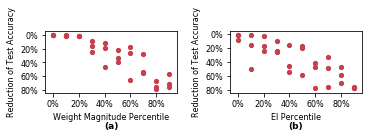

In [150]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [weight_database[r+1]['accuracies'][p] for p in range(0, 100, 10)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax.scatter(list(range(0, 100, 10)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax.set_xlabel('Weight Magnitude Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)


ax.text(0.5, -0.58, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 10)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 10)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.4, bottom=0.32, top=0.8, left=0.1, right=0.9)
plt.savefig('figures/ablation-comparison.pdf')

# Perform ablation in 5% intervals

In [13]:
import math

In [14]:
database = defaultdict(dict)

In [15]:
t = tqdm(total=len(mnist_runs_datapoints) * 4)
for i, frames in enumerate(mnist_runs_datapoints):
    database[i+1] = {}
    ls = []
    for (in_n, out_n) in MNIST_LAYERS:
        ls.append(nn.Linear(in_n, out_n, bias=False))
        ls.append(nn.Sigmoid())
    final_network = nn.Sequential(*ls).to(device)
    final_top = topology_of(final_network, input=torch.zeros((1, 25)).to(device))
    final_network.load_state_dict(frames[-1]['model'])
    
    lyrs = [0, 2, 4, 6]
    database[i+1]['EIs'] = {}
    for l in lyrs:
        database[i+1]['EIs'][l] = ei_of_layer_matrix(final_network[l], final_top,
                                                        samples=int(2e5),
                                                        in_range=(0, 1),
                                                        in_bins=8,
                                                        out_range=(0, 1),
                                                        out_bins=8,
                                                        activation=nn.Sigmoid(),
                                                        device=device)
        t.update()

In [16]:
t = tqdm(total=len(mnist_runs_datapoints) * 20)

for r, frames in enumerate(mnist_runs_datapoints):
    database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 5):
        
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4, 6]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = database[r+1]['EIs'][l]
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            num = round(5 / 100 * len(indices_and_values))
            i = int((percentile + 5 - 1) / 100 * len(indices_and_values))
            start = (i - num) if (i - num) >= 0 else 0
            end = i
#             start = int(percentile / 100 * len(indices_and_values))
#             end = int(((percentile + 5) / 100 * len(indices_and_values)))
            print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43

Text(0.5, -0.58, '(b)')

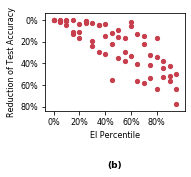

In [20]:
fig = plt.figure(figsize=(5.5, 1.8))

ax2 = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

In [67]:
weight_database = defaultdict(dict)

In [68]:
t = tqdm(total=len(mnist_runs_datapoints) * 20)

for r, frames in enumerate(mnist_runs_datapoints):
    weight_database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 5):
        
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4, 6]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = unmodified_network[l].weight.T.cpu().detach().numpy()
            eis = np.abs(eis)
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            num = round(5 / 100 * len(indices_and_values))
            i = int((percentile + 5 - 1) / 100 * len(indices_and_values))
            start = (i - num) if (i - num) >= 0 else 0
            end = i
#             start = int(percentile / 100 * len(indices_and_values))
#             end = int(((percentile + 5) / 100 * len(indices_and_values)))
            print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        weight_database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43

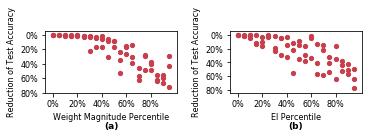

In [23]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [weight_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax.set_xlabel('Weight Magnitude Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)


ax.text(0.5, -0.58, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.4, bottom=0.32, top=0.8, left=0.1, right=0.9)
# plt.savefig('figures/ablation-comparison-5pct.pdf')

# Perform ablation based on change in $EI_{parts}$

In [54]:
ei_database = {}

### compute unablated $EI_{parts}$

In [55]:
t = tqdm(total=len(mnist_runs_datapoints) * 4)
for i, frames in enumerate(mnist_runs_datapoints):
    ei_database[i+1] = {}
    ls = []
    for (in_n, out_n) in MNIST_LAYERS:
        ls.append(nn.Linear(in_n, out_n, bias=False))
        ls.append(nn.Sigmoid())
    final_network = nn.Sequential(*ls).to(device)
    final_top = topology_of(final_network, input=torch.zeros((1, 25)).to(device))
    final_network.load_state_dict(frames[-1]['model'])
    
    lyrs = [0, 2, 4, 6]
    ei_database[i+1]['baseline'] = {}
    for l in lyrs:
        ei_database[i+1]['baseline'][l] = ei_of_layer(final_network[l], final_top,
                                                        samples=int(2e5),
                                                        in_range=(0, 1),
                                                        in_bins=8,
                                                        out_range=(0, 1),
                                                        out_bins=8,
                                                        activation=nn.Sigmoid(),
                                                        device=device)
        t.update()

### Compute ablated $EI_{parts}$

In [56]:
t = tqdm(total=len(mnist_runs_datapoints) * 4)

for r, frames in enumerate(mnist_runs_datapoints):
    ei_database[r+1]['ablated'] = {}
    ls = []
    for (in_n, out_n) in MNIST_LAYERS:
        ls.append(nn.Linear(in_n, out_n, bias=False))
        ls.append(nn.Sigmoid())
    unmodified_network = nn.Sequential(*ls).to(device)
    unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
    unmodified_network.load_state_dict(frames[-1]['model'])
    
    lyrs = [0, 2, 4, 6]
    for l in lyrs:
        ei_database[r+1]['ablated'][l] = {}
        in_n, out_n = unmodified_network[l].weight.T.shape
        for i, j in product(range(in_n), range(out_n)):
            ls = []
            for (in_n, out_n) in MNIST_LAYERS:
                ls.append(nn.Linear(in_n, out_n, bias=False))
                ls.append(nn.Sigmoid())
            modified_network = nn.Sequential(*ls).to(device)
            modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
            modified_network.load_state_dict(frames[-1]['model'])
            modified_network[l].weight.data.T[i, j] = 0
            ei_database[r+1]['ablated'][l][(i, j)] = ei_of_layer(modified_network[l], modified_top,
                                                        samples=int(2e5),
                                                        in_range=(0, 1),
                                                        in_bins=8,
                                                        out_range=(0, 1),
                                                        out_bins=8,
                                                        activation=nn.Sigmoid(),
                                                        device=device)
        t.update()
            


In [62]:
t = tqdm(total=len(mnist_runs_datapoints) * 20)

for r, frames in enumerate(mnist_runs_datapoints):
    ei_database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 5):
        
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 25)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in MNIST_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 25)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4, 6]
        for l in lyrs:
            eis = ei_database[r+1]['ablated'][l]
            indices_and_values = []
            for (i, j) in eis:
                baseline = ei_database[r+1]['baseline'][l]
                modified = ei_database[r+1]['ablated'][l][(i, j)]
                indices_and_values.append(((i, j), abs(baseline - modified)))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            num = round(5 / 100 * len(indices_and_values))
            i = int((percentile + 5 - 1) / 100 * len(indices_and_values))
            start = (i - num) if (i - num) >= 0 else 0
            end = i
#             start = int(percentile / 100 * len(indices_and_values))
#             end = int(((percentile + 5) / 100 * len(indices_and_values)))
            print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        ei_database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43
8 10
8 10
6 8
43 51
10 12
10 12
8 10
50 58
12 14
12 14
9 11
58 66
13 15
13 15
11 13
65 73
15 17
15 17
12 14
73 81
17 19
17 19
14 16
80 88
19 21
19 21
15 17
88 96
21 23
21 23
17 19
95 103
22 24
22 24
18 20
103 111
24 26
24 26
20 22
110 118
26 28
26 28
21 23
118 126
28 30
28 30
23 25
125 133
30 32
30 32
24 26
133 141
31 33
31 33
26 28
140 148
33 35
33 35
27 29
0 6
0 1
0 1
0 1
5 13
1 3
1 3
0 2
13 21
3 5
3 5
2 4
20 28
4 6
4 6
3 5
28 36
6 8
6 8
5 7
35 43

Text(0.5, -0.58, '(b)')

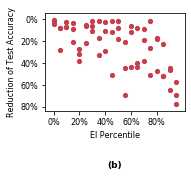

In [63]:
fig = plt.figure(figsize=(5.5, 1.8))

ax2 = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [ei_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

In [70]:
from sklearn.linear_model import LinearRegression

In [134]:
ei_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        ei_datapoints.append((p, ablated_accuracy - baseline))

In [135]:
x, y = zip(*ei_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)

In [137]:
reg = LinearRegression().fit(x, y)

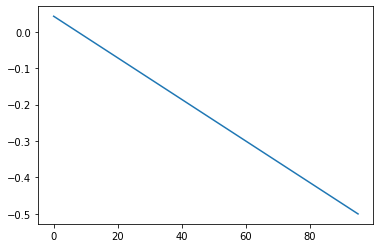

In [138]:
plt.plot(x[0:20, :], reg.predict(x[0:20, :]))

In [139]:
reg.score(x, y)

0.6241116811290381

In [141]:
weight_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = weight_database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        weight_datapoints.append((p, ablated_accuracy - baseline))

In [142]:
x, y = zip(*weight_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)

In [143]:
reg = LinearRegression().fit(x, y)

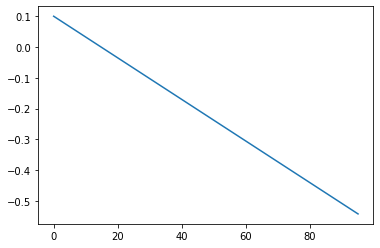

In [146]:
plt.plot(x[0:20, :], reg.predict(x[0:20, :]))

In [147]:
reg.score(x, y)

0.7557744178474619

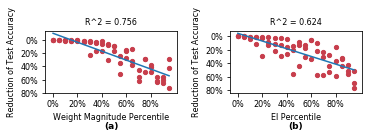

In [156]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [weight_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

weight_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = weight_database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        weight_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*weight_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)


# ax.set_xlabel('Type of Edge', fontsize=15)
ax.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax.set_xlabel('Weight Magnitude Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)


ax.text(0.5, -0.58, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)
    
ei_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        ei_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*ei_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax2.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax2.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.4, bottom=0.32, top=0.8, left=0.1, right=0.9)
plt.savefig('figures/ablation-comparison-5pct-withregression.pdf')

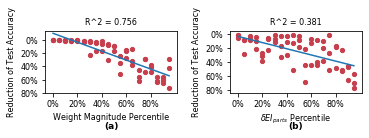

In [76]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [weight_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

weight_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = weight_database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        weight_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*weight_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)


# ax.set_xlabel('Type of Edge', fontsize=15)
ax.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax.set_xlabel('Weight Magnitude Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)


ax.text(0.5, -0.58, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [ei_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)
    
ei_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = ei_database[r]['accuracies'][p]
        baseline = mnist_runs_datapoints[r-1][-1]['testing_accuracy']
        ei_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*ei_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax2.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax2.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('$\delta EI_{parts}$ Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.4, bottom=0.32, top=0.8, left=0.1, right=0.9)
plt.savefig('figures/eipartschange-ablation-comparison-5pct-withregression.pdf')


# Let's do Iris now

In [172]:
########### PARAMS ############
BINS = 8
IRIS_LAYERS = [(4, 5), (5, 5), (5, 3)]
ACTIVATION = nn.Sigmoid()
RUNS = 3
FREQUENCY = 50 # epochs per measurement
EPOCHS = 4000
# BATCH_SIZE = 10 this is fixed
# print("Total Measurements: {}".format(EPOCHS / FREQUENCY))

top_str = ""
for i, l in enumerate(IRIS_LAYERS):
    if i == len(IRIS_LAYERS)-1:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-{out_w}"
    else:
        in_w = l[0]
        out_w = l[1]
        top_str += f"{in_w}-"

### Load up Iris dataset

In [173]:
import sklearn.datasets
from random import shuffle

In [174]:
###### Create Datasets ######
data = list(zip(*sklearn.datasets.load_iris(return_X_y=True)))
shuffle(data)
inputs, labels = zip(*data)
inputs = np.array(inputs) / 8
training_inputs, training_labels = inputs[:100], labels[:100]
testing_inputs, testing_labels = inputs[100:], labels[100:]

training_data = torch.utils.data.TensorDataset(torch.tensor(training_inputs, dtype=dtype),
                                               F.one_hot(torch.tensor(training_labels, dtype=torch.long)).to(dtype))
testing_data = torch.utils.data.TensorDataset(torch.tensor(testing_inputs, dtype=dtype),
                                               F.one_hot(torch.tensor(testing_labels, dtype=torch.long)).to(dtype))

training_loader = torch.utils.data.DataLoader(training_data,
                            batch_size=10,
                            shuffle=True)

training_metrics_loader = torch.utils.data.DataLoader(training_data,
                            batch_size=10,
                            shuffle=True)

testing_loader = torch.utils.data.DataLoader(testing_data,
                            batch_size=10,
                            shuffle=False)

testing_metrics_loader = torch.utils.data.DataLoader(testing_data,
                            batch_size=10,
                            shuffle=False)

### Load up Iris networks

In [175]:
exp_dir = Path('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer')
run_folders = [exp_dir / f"run{i}-frames" for i in range(1, RUNS+1)]
# run_folders = [here / "run1-frames"]
runs_frames = [list(run.glob('*.frame')) for run in run_folders]
print(run_folders)

[PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run1-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run2-frames'), PosixPath('/home/eric/Code/deep-ei-private/runs/iris/fourth/sigmoid-fixed-longer/run3-frames')]


In [176]:
all(d.exists() for d in run_folders)

True

In [178]:
def get_measures(path_to_frame):
    frame = torch.load(path_to_frame)
    measure_names = [
        'batches',
        'epochs',
        'training_loss',
        'testing_loss',
        'training_accuracy',
        'testing_accuracy',
        'model'
    ]
    for (start_i, end_i) in combinations_with_replacement(range(len(IRIS_LAYERS)), 2):
        measure_names.append(f"pairwise-ei:{start_i}-{end_i}")
        measure_names.append(f"pairwise-sensitivity:{start_i}-{end_i}")
        measure_names.append(f"vector-ei:{start_i}-{end_i}")
    measures = {}
    for name in measure_names:
        if type(frame[name]) is torch.Tensor:
            measures[name] = frame[name].item()
        else:
            measures[name] = frame[name]
    return measures

In [179]:
iris_runs_datapoints = [[get_measures(path) for path in run_frames] for run_frames in runs_frames]
for iris_run_datapoints in iris_runs_datapoints:
    iris_run_datapoints.sort(key=lambda f: f['batches'])

In [180]:
iris_ltl = {
    0: 'X',
    1: 'T1',
    2: 'T2',
    3: 'Y'
}

## do ablation calculations

In [193]:
import math

In [202]:
database = defaultdict(dict)

In [203]:
t = tqdm(total=len(iris_runs_datapoints) * 3)
for i, frames in enumerate(iris_runs_datapoints):
    database[i+1] = {}
    ls = []
    for (in_n, out_n) in IRIS_LAYERS:
        ls.append(nn.Linear(in_n, out_n, bias=False))
        ls.append(nn.Sigmoid())
    final_network = nn.Sequential(*ls).to(device)
    final_top = topology_of(final_network, input=torch.zeros((1, 4)).to(device))
    final_network.load_state_dict(frames[-1]['model'])
    
    lyrs = [0, 2, 4]
    database[i+1]['EIs'] = {}
    for l in lyrs:
        database[i+1]['EIs'][l] = ei_of_layer_matrix(final_network[l], final_top,
                                                        samples=int(2e5),
                                                        in_range=(0, 1),
                                                        in_bins=8,
                                                        out_range=(0, 1),
                                                        out_bins=8,
                                                        activation=nn.Sigmoid(),
                                                        device=device)
        t.update()

In [204]:
t = tqdm(total=len(iris_runs_datapoints) * 20)

for r, frames in enumerate(iris_runs_datapoints):
    database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 5):
        
        ls = []
        for (in_n, out_n) in IRIS_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 4)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in IRIS_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 4)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = database[r+1]['EIs'][l]
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            num = round(5 / 100 * len(indices_and_values))
            i = int((percentile + 5 - 1) / 100 * len(indices_and_values))
            start = (i - num) if (i - num) >= 0 else 0
            end = i
#             start = int(percentile / 100 * len(indices_and_values))
#             end = int(((percentile + 5) / 100 * len(indices_and_values)))
            print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14
0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14
0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14


Text(0.5, -0.58, '(b)')

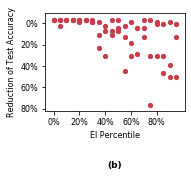

In [205]:
fig = plt.figure(figsize=(5.5, 1.8))

ax2 = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = mnist_runs_datapoints[0][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

In [206]:
weight_database = defaultdict(dict)

In [207]:
t = tqdm(total=len(iris_runs_datapoints) * 20)

for r, frames in enumerate(iris_runs_datapoints):
    weight_database[r+1]['accuracies'] = {}
    for percentile in range(0, 100, 5):
        
        ls = []
        for (in_n, out_n) in IRIS_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        unmodified_network = nn.Sequential(*ls).to(device)
        unmodified_top = topology_of(unmodified_network, input=torch.zeros((1, 4)).to(device))
        unmodified_network.load_state_dict(frames[-1]['model'])
        ls = []
        for (in_n, out_n) in IRIS_LAYERS:
            ls.append(nn.Linear(in_n, out_n, bias=False))
            ls.append(nn.Sigmoid())
        modified_network = nn.Sequential(*ls).to(device)
        modified_top = topology_of(modified_network, input=torch.zeros((1, 4)).to(device))
        modified_network.load_state_dict(frames[-1]['model'])
        
        lyrs = [0, 2, 4]
        for l in lyrs:
#             print(f"query: database[{r+1}]['EIs'][{l}]")
            eis = unmodified_network[l].weight.T.cpu().detach().numpy()
            eis = np.abs(eis)
            indices_and_values = []
            for i in range(eis.shape[0]):
                for j in range(eis.shape[1]):
                    indices_and_values.append(((i, j), eis[i][j].item()))
            indices_and_values.sort(key=lambda e: e[1], reverse=False)
            num = round(5 / 100 * len(indices_and_values))
            i = int((percentile + 5 - 1) / 100 * len(indices_and_values))
            start = (i - num) if (i - num) >= 0 else 0
            end = i
#             start = int(percentile / 100 * len(indices_and_values))
#             end = int(((percentile + 5) / 100 * len(indices_and_values)))
            print(start, end)
            for ((i, j), _) in indices_and_values[start:end]:
                modified_network[l].weight.T[i][j] = 0.0
        
        # --------------------------------------
        #        Compute Modified Accuracy
        # --------------------------------------
        outof = 0
        testing_accuracy = 0
        with torch.no_grad():
            for sample, target in testing_metrics_loader:
                output = modified_network(sample.to(device))
                _, pred = torch.max(output, 1)
                _, answer = torch.max(target.to(device), 1)
                testing_accuracy += (pred == answer).sum().item()
                outof += len(target)
        testing_accuracy = testing_accuracy / outof
        weight_database[r+1]['accuracies'][percentile] = testing_accuracy
        t.update()
    

0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14
0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14
0 0
0 1
0 0
0 1
1 2
0 1
1 2
2 3
1 2
2 3
3 4
1 2
3 4
5 6
2 3
4 5
6 7
3 4
5 6
7 8
4 5
6 7
8 9
4 5
7 8
10 11
5 6
8 9
11 12
6 7
9 10
12 13
7 8
10 11
13 14
7 8
11 12
15 16
8 9
12 13
16 17
9 10
13 14
17 18
10 11
14 15
18 19
10 11
15 16
20 21
11 12
16 17
21 22
12 13
17 18
22 23
13 14
18 19
23 24
13 14


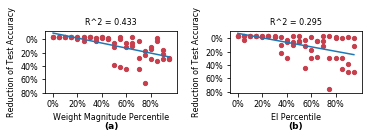

In [209]:
fig = plt.figure(figsize=(5.5, 1.8))

ax = plt.subplot(1, 2, 1)
for r in range(3):
    ablated_accuracies = [weight_database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = iris_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)

weight_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = weight_database[r]['accuracies'][p]
        baseline = iris_runs_datapoints[r-1][-1]['testing_accuracy']
        weight_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*weight_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)


# ax.set_xlabel('Type of Edge', fontsize=15)
ax.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax.set_xlabel('Weight Magnitude Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)


ax.text(0.5, -0.58, "(a)", size=9, ha="center", weight="bold", 
         transform=ax.transAxes)


ax2 = plt.subplot(1, 2, 2)
for r in range(3):
    ablated_accuracies = [database[r+1]['accuracies'][p] for p in range(0, 100, 5)]
    baseline = iris_runs_datapoints[r][-1]['testing_accuracy']
    accuracy_destruction = [a - baseline for a in ablated_accuracies]
    ax2.scatter(list(range(0, 100, 5)), accuracy_destruction, color=infernoMap(2, 3), s=18)
    
ei_datapoints = []
for r in [1, 2, 3]:
    for p in range(0, 100, 5):
        ablated_accuracy = database[r]['accuracies'][p]
        baseline = iris_runs_datapoints[r-1][-1]['testing_accuracy']
        ei_datapoints.append((p, ablated_accuracy - baseline))      
x, y = zip(*ei_datapoints)
x = np.expand_dims(np.array(x), axis=1)
y = np.expand_dims(np.array(y), axis=1)
reg = LinearRegression().fit(x, y)
ax2.plot(x[0:20, :], reg.predict(x[0:20, :]))
ax2.set_title("R^2 = {:.3f}".format(reg.score(x, y)), fontsize=8)

# ax.set_xlabel('Type of Edge', fontsize=15)
ax2.set_ylabel('Reduction of Test Accuracy',fontsize=8)
ax2.set_xlabel('EI Percentile', fontsize=8)

plt.xticks(ticks=list(range(0, 100, 20)), 
           labels=[f"{p}%" for p in range(0, 100, 20)],
           fontsize=8)

plt.yticks(ticks=[-0, -0.20, -0.40, -0.60, -0.80], 
           labels=["0%", "20%", "40%", "60%", "80%"],
           fontsize=8)
ax2.text(0.5, -0.58, "(b)", size=9, ha="center", weight="bold", 
         transform=ax2.transAxes)

plt.subplots_adjust(wspace=0.4, bottom=0.32, top=0.8, left=0.1, right=0.9)
plt.savefig('figures/iris-ablation-comparison-5pct-withregression.pdf')